In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg
from topologyLib import kernel2connection, gkern2

import scipy.ndimage.filters as fi
from time import time
%matplotlib inline

In [73]:
# Need to tune for width and intensity too
def generateMovingFFT(F, iteration, direction, sigma, intensity, noise=0.2, size = 15):
    aux1 = 1#(1/(sigma*np.sqrt(2*np.pi)))
    x = np.array(range(size))
    res = aux1*np.exp(-np.power(x-F,2)/(2*(np.power(sigma,2))))
    #res = res #+ (np.random.rand(size)-0.5)*noise+noise/2
    x=res 
    plt.plot(res)
    plt.show()
    
    #print it%14<12
    if False:#iteration%14<12:
        j=int(iteration%12)/2
        aux1 = (1/(sigma*np.sqrt(2*np.pi)))
        x = np.array(range(size))
        res = aux1*np.exp(-np.power(x-(F+int(direction*j)),2)/(np.power(sigma,2)))#/float(2*s1)
        res = res + (np.random.rand(size)-0.5)*noise+noise/2
        x=res
        #for i in np.array(range(3))-1:
        #    n = min(max(F+i+int(direction*j), 0),size-1)
        #    x[n]=1-0.3*abs(i)
    #print x
    return x#.reshape(size,1)
def sigmoid(x,k):
    return 1 / (1 + np.exp(-x))

293 1 0


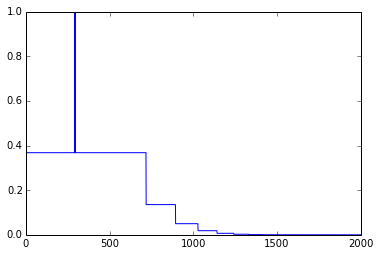

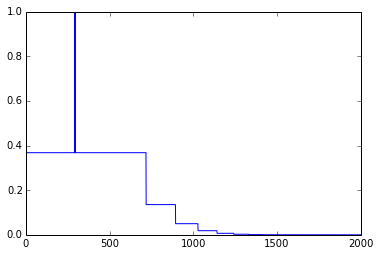

293 1 1


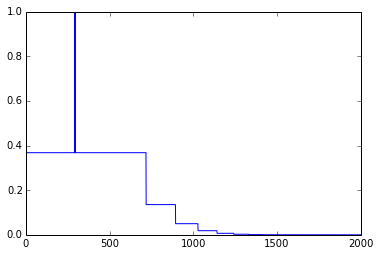

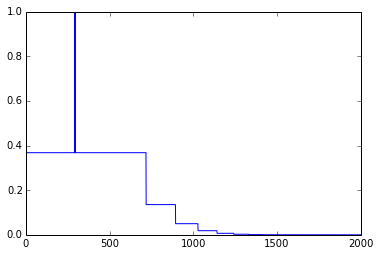

293 1 2


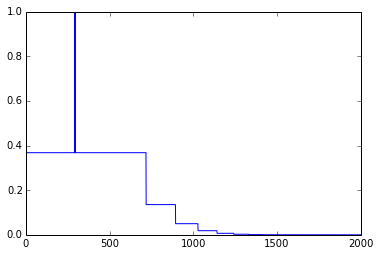

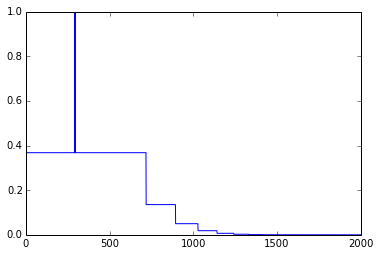

293 1 3


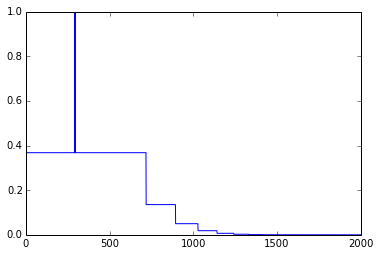

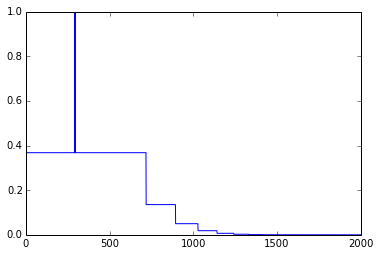

293 1 4


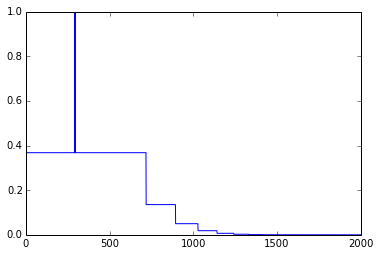

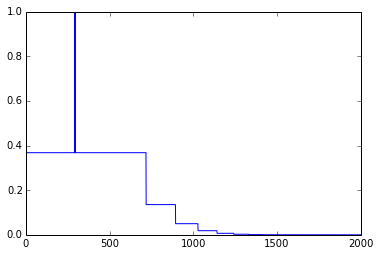

293 1 5


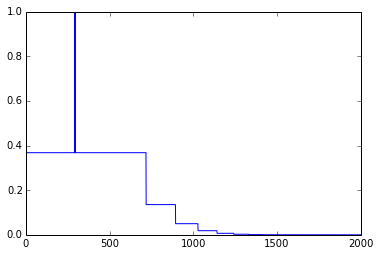

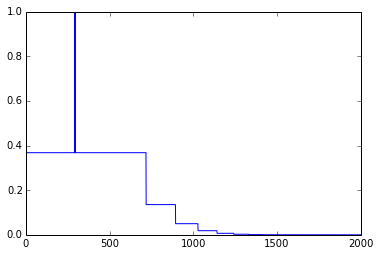

293 1 6


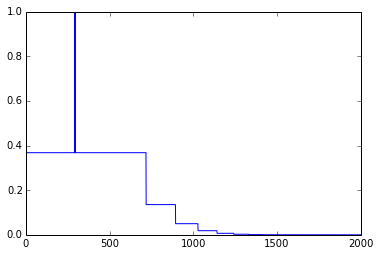

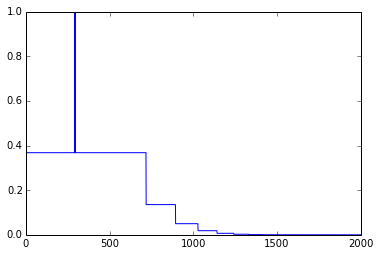

293 1 7


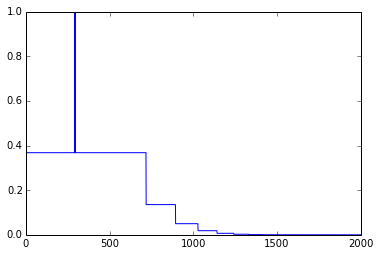

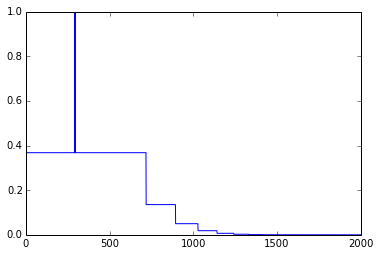

293 1 8


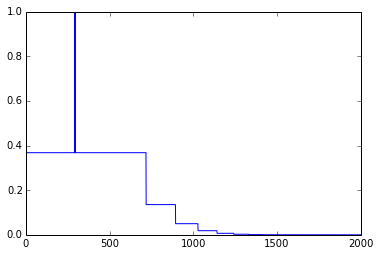

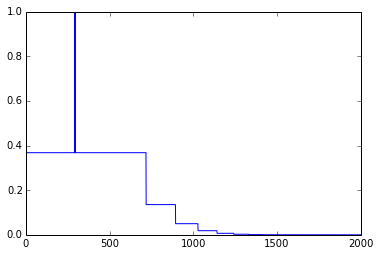

293 1 9


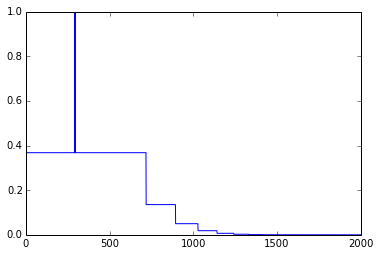

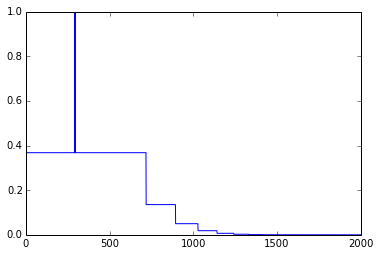

293 1 10


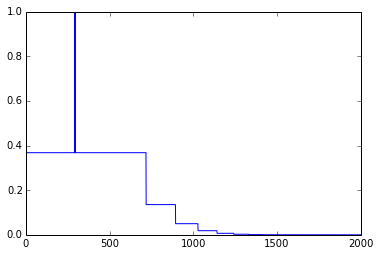

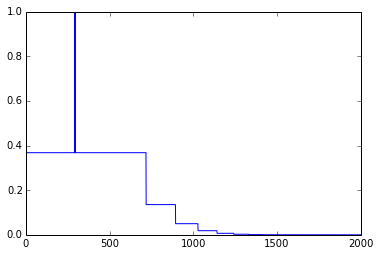

293 1 11


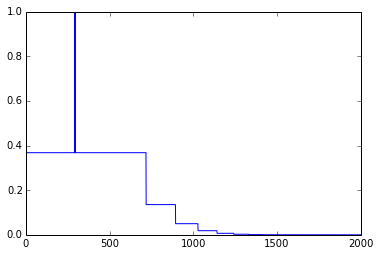

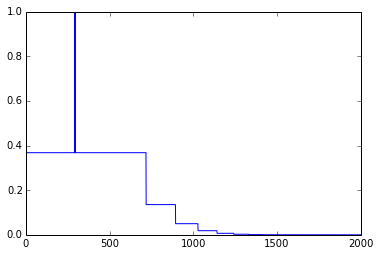

293 1 12


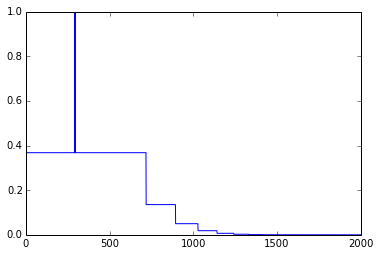

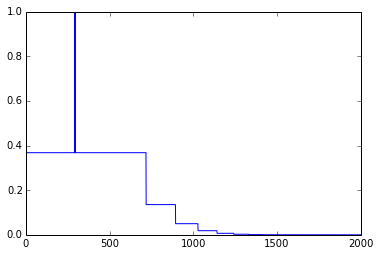

293 1 13


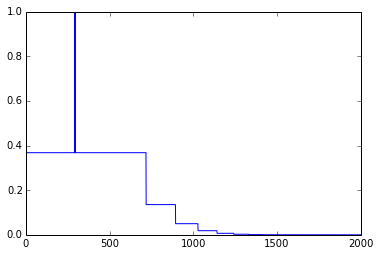

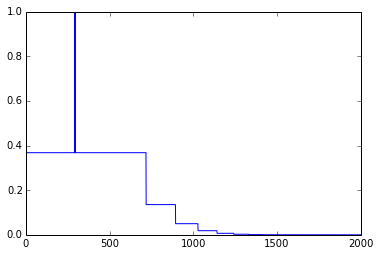

623 1 14


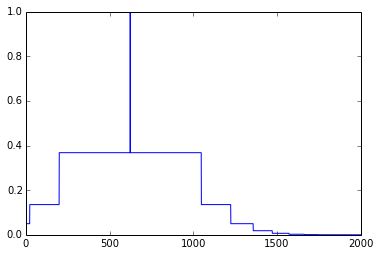

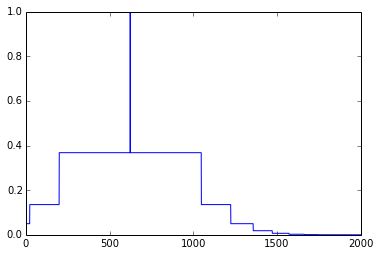

623 1 15


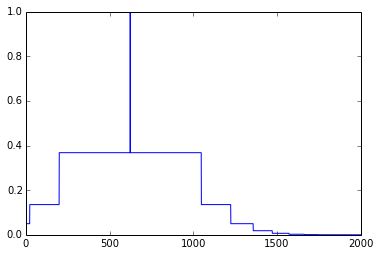

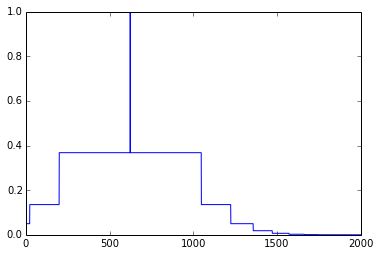

623 1 16


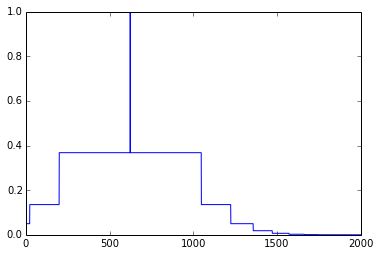

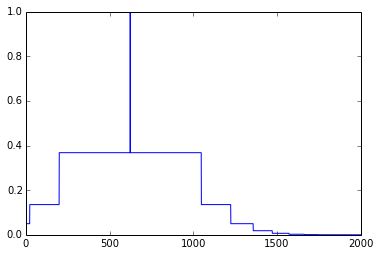

623 1 17


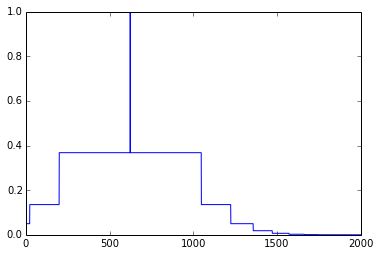

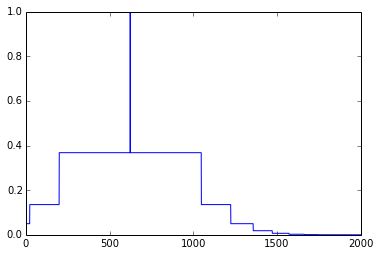

623 1 18


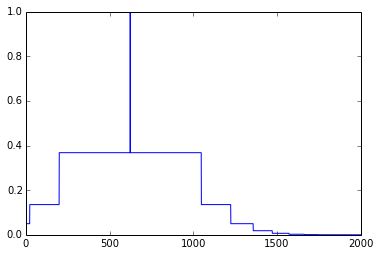

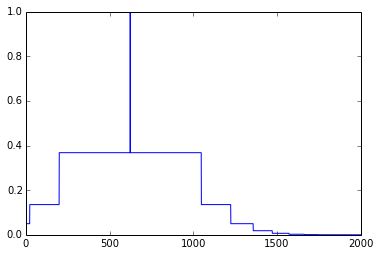

623 1 19


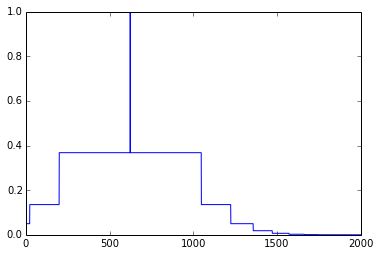

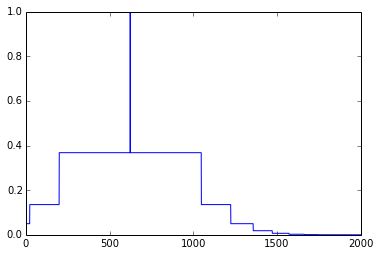

623 1 20


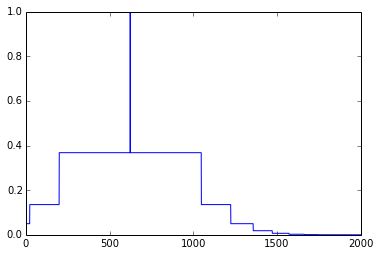

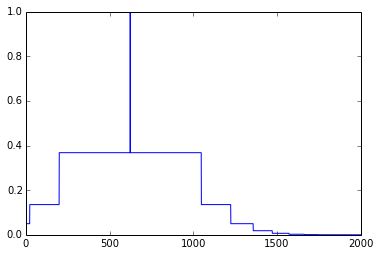

623 1 21


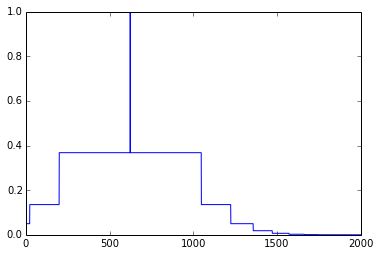

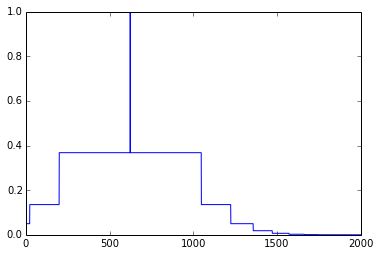

623 1 22


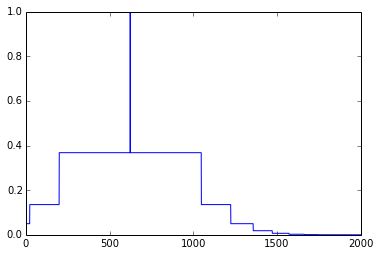

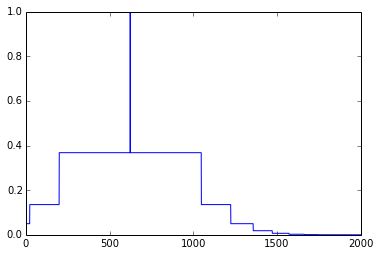

623 1 23


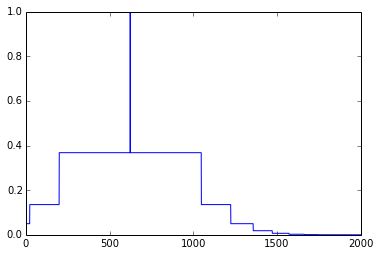

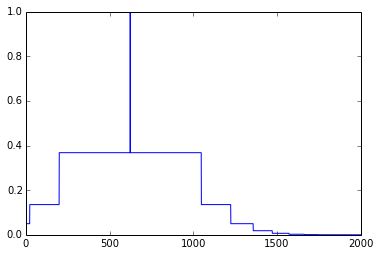

623 1 24


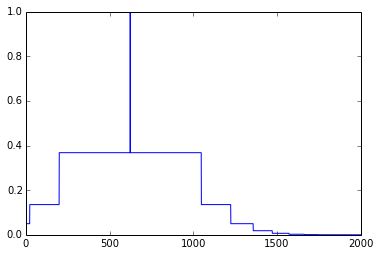

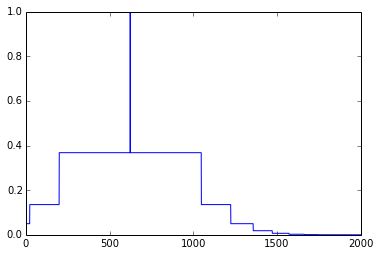

In [74]:
# Test the FFT Generation
Size=2000
freqs = np.random.choice(range(Size))
dirs = [1]
for i in range(25):
    if i%14==0:
        F=np.random.choice(freqs)
        D = np.random.choice(dirs)
    print F, D, i
        
    plt.plot(generateMovingFFT(F,i,D,300,0.6,0.02,Size))
    plt.show()

In [ ]:
# Re initialize variables: 
N=(46,1)
max_distance_x= 10. #units
max_distance_y= 1. #units
neurons = np.zeros(N)

x = np.arange(0,max_distance_x,max_distance_x/N[0]).reshape(N[0],1)*np.ones(N)
y = np.arange(0,max_distance_y,max_distance_y/N[1]).reshape(1,N[1])*np.ones(N)
x=x.reshape(N)
y=y.reshape(N)
print y.shape

connections = np.identity((neurons.size))

distances = np.zeros(connections.shape)
x = x*np.ones((x.size,x.size))
y = y*np.ones((y.size,y.size))

dx = x-x.transpose()
dy = y-y.transpose()

distances = dx**2+dy**2



dw = np.zeros(connections.shape)
dC = np.zeros(connections.shape)
k=1 #influence of distance
K=0.5  #Max probability
_distances = 1/(1+k*distances)
plt.imshow(_distances)
plt.show()
aux_kernel = np.ones((1,2*distances.shape[1]))

In [ ]:
# Run simulation
C=0.0000001
alpha = 0.2
a=connections
LR=0.9
asd=0
X=np.zeros(neurons.shape)
not_identity=(np.identity(X.size)==0) #Will never create connections with oneself
W_recursive = 0.00005
for i in range(1000000):
    #X = np.random.rand(N[0],N[1])
    if i%14==0:
        F=np.random.choice(freqs)
        D = np.random.choice(dirs)
    #Generate input
    inp = generateMovingFFT(F,i,D)
    #Compute network activity
    X=alpha*(np.dot(c_inp.T,inp) + W_recursive*np.dot(connections,X))+(1-(1+W_recursive)*alpha)*np.dot(np.identity(X.size),X)
    X=sigmoid(X,1)
    mask_C_0 = connections<=0
    
    # Compute probability of connection
    probabilities = K*np.dot(connections*_distances,_distances.transpose())*mask_C_0 # sg.convolve(K*connections*np.dot(_distances,_distances.transpose()), aux_kernel,'same')*mask_C_0.mask
    # Compute Hebbian plasticity (to weight the probability)
    dw = np.dot(X,X.transpose())-np.dot(X, np.dot(X.transpose(),C*np.ones((connections.shape[0],connections.shape[1]))) )# Oja, right now
    #Warnings!!
    if np.isnan(dw).any():
        print 'error: NAN found in dw. At iteration: ' + str(i)
        break

    # Create new dendrite if weighted probability is greater than 0.7
    new_dendrites = probabilities + dw - 0.7 #probabilities - np.random.rand(connections.shape[0],connections.shape[1])
    dC = (new_dendrites > 0)* dw
    # update
    connections = connections + (mask_C_0*dC)#+ (connections>0)*np.dot(X,X.transpose())-np.dot(X, np.dot(X.transpose(),connections) )# Oja, right now
    # Scale connections
    connections[not_identity] /= np.sum(connections[not_identity],0)
    
    # Add LR for non-diagonal, non-zero weights
    dC = np.dot(X,X.T)-np.dot(X, np.dot(X.T,connections))
    #plt.plot(X)
    #plt.show()
    dC*=not_identity
    if i%10000000 ==0:
        plt.imshow(np.dot(X,X.T),vmin=0, vmax=1)
        plt.show()
        plt.imshow(np.dot(X, np.dot(X.T,connections)),vmin=0, vmax=1)
        plt.show()
        plt.plot(X)
        plt.show()
    #connections[connections>0] += LR*(dC[connections>0])
    #connections[not_identity] /= np.sum(connections[not_identity],0)

In [ ]:
plt.imshow(connections*not_identity,vmin=0,vmax=1)
plt.title('current Connections')
plt.show()
plt.imshow(connections-a,vmin=-1,vmax=1)
a=connections

In [ ]:
# Need to analise the data

In [ ]:
# Auditory simulation:
alpha = 0.5
LR=0.9
asd=0
X=np.zeros(neurons.shape)
for i in range(100):
    #X = np.random.rand(N[0],N[1])
    if i%14==0:
        F=np.random.choice(freqs)
        D = np.random.choice(dirs)
    print F, D, i
    inp = generateMovingFFT(F,i,D)
    
    X=alpha*(np.dot(c_inp.T,inp) + 0.2*np.dot(connections,X))+(1-1.2*alpha)*np.dot(np.identity(X.size),X)
    X=sigmoid(X,1)
    plt.plot(X)
    plt.show()